In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/data.csv')
#df = pd.read_csv('data.csv')

# Ejercicio 1

In [3]:
counts = df['target'].value_counts()
percentages = df['target'].value_counts(normalize=True)
pd.DataFrame({'counts': counts, 'percentages': percentages})

,counts,percentages
target,,
0,343,0.686
1,157,0.314


Notamos que estamos ante un dataset algo desbalanceado, por lo que separaremos los datos de forma estratificada.

In [4]:

def train_test_split(df,train_size=0.8): #estratificado
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    n = df.shape[0]  #cantidad de filas
    cantPos = df['target'].sum() #positivas son 1, negativas son 0
    #columna 'target' tiene valores 0 y 1
    proporcion = cantPos / n

    cant_en_train = int(n*train_size)
    cant_en_validacion = n - cant_en_train

    res = []
    cant_positivas = int(proporcion * cant_en_validacion)
    cant_negativas = cant_en_validacion - cant_positivas

    contador_positivos, contador_negativos = 0, 0
    for index, value in enumerate(df['target']):
        if value == 0:
            contador_negativos += 1
            res.append(index)

        if contador_negativos == cant_negativas:
            break
    for index, value in enumerate(df['target']):
        if value == 1:
            contador_positivos += 1
            res.append(index)

        if contador_positivos == cant_positivas:
            break

    df_dev = df.loc[~df.index.isin(res)].reset_index(drop=True)
    df_eval = df.loc[res].reset_index(drop=True)
    return df_dev,df_eval

In [5]:
df_dev , df_eval =  train_test_split(df,0.9)


# Ejercicio 2

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score , average_precision_score
from sklearn.model_selection import cross_val_predict

In [7]:
X_train = df_dev.drop(columns=['target']).values

y_train = df_dev['target'].values

X_eval   = df_eval.drop(columns=['target']).values

y_eval   =  df_eval['target'].values

## 2.1


In [8]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=51)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=51)

## 2.2


In [9]:
scoring = ['accuracy', 'roc_auc', 'average_precision']

#Dado que el dataset está algo desbalanceado, usamos StratifiedKFold
skf = StratifiedKFold(n_splits=5)

cv_results = cross_validate(tree_clf, X_train, y_train, cv = skf, scoring = scoring, return_train_score = True)

predicted_labels = cross_val_predict(tree_clf, X_train, y_train, cv = skf)

df_resultados_ej_2_2 = pd.DataFrame({key: cv_results[key] for key in list(cv_results.keys())[2:]})
df_resultados_ej_2_2.index = df_resultados_ej_2_2.index + 1 # asi el indice del df se correponde con el k-Fold
metricas_globales = [accuracy_score(y_train, predicted_labels), np.nan, roc_auc_score(y_train, predicted_labels), np.nan,average_precision_score(y_train, predicted_labels), np.nan]


df_resultados_ej_2_2.loc['Promedio'] = df_resultados_ej_2_2.mean()
df_resultados_ej_2_2.loc['Global'] = metricas_globales

df_resultados_ej_2_2


,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_average_precision,train_average_precision
1,0.655556,0.813889,0.612210,0.774068,0.378969,0.665387
2,0.677778,0.811111,0.678632,0.832987,0.459322,0.663596
3,0.711111,0.811111,0.618952,0.799618,0.415606,0.659502
4,0.700000,0.805556,0.637961,0.847793,0.436165,0.670116
5,0.711111,0.808333,0.674539,0.820193,0.509735,0.711133
Promedio,0.691111,0.810000,0.644459,0.814932,0.439959,0.673947
Global,0.691111,NaN,0.594064,NaN,0.382060,NaN


## 2.3

In [10]:
alturas = [3, 5, None]
criterios = ["gini", "entropy"]
resultados = {}

for criterio in criterios:
    for altura in alturas:

        tree = DecisionTreeClassifier(max_depth = altura, criterion = criterio, random_state = 51)

        cv_results_grid = cross_validate(tree, X_train, y_train, cv = skf, scoring = 'accuracy', return_train_score = True)

        accuracy_train = cv_results_grid['train_score'].mean()

        accuracy_test =  cv_results_grid['test_score'].mean()



        resultados[(altura, criterio)] = (accuracy_train,accuracy_test)

results_df = pd.DataFrame(resultados.values(), index=resultados.keys(), columns=['Accuracy (training)', 'Accuracy (testing)'])

results_df

,,Accuracy (training),Accuracy (testing)
3,gini,0.810000,0.691111
5,gini,0.925000,0.657778
NaN,gini,1.000000,0.622222
3,entropy,0.786111,0.682222
5,entropy,0.896667,0.686667
NaN,entropy,1.000000,0.642222


## 2.4
Notamos que en Test el criterio de corte Gini da siempre mejor que entropy para cualquier altura.
Sera porque entropy tiende a producir arboles mas equilibrados y nuestro data set esta desbalanceado?

Asimismo tambien vemos que a medida que aumenta la altura del arbol, decae el rendimiento en el test set y aumenta en el train set, independientemente del criterio de corte utilizado.

# Ejercicio 3

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import scipy
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

## Árboles de decisión

In [12]:
# Hay que revisar en la documentacion del modelo cada parametro y usar una distribucion con los valores mas probables
# Las listas son interpretadas como distribuciones uniformes discretas

# Comento los parámetros que generan errores
dist_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': scipy.stats.randint(1,40), #puede ser float
    'min_samples_split': scipy.stats.randint(2,20), #puede ser float
    'min_samples_leaf': scipy.stats.randint(1,20),
    #'min_weight_fraction_leaf':scipy.stats.uniform(0,1) ,
    'max_features': scipy.stats.randint(1,50),
    'random_state': [42],
    'max_leaf_nodes': scipy.stats.randint(2,len(X_train)),
    #'min_impurity_decrease': scipy.stats.uniform(0,0.1),
    #'class_weight': {i: scipy.stats.uniform(0,1) for i in range(len(X_train[0]))},
    #'ccp_alpha': scipy.stats.uniform(0,0.1),
}

tree = DecisionTreeClassifier()
n_iter_search = 50    # Esto es la cantidad de configuraciones que pruebo
random_search = RandomizedSearchCV(estimator=tree, param_distributions=dist_params, scoring='roc_auc', cv=skf,  n_iter=n_iter_search)
random_search.fit(X_train, y_train)

mejor_modelo = random_search.best_estimator_
mejor_score = random_search.best_score_
print("Mejor modelo:", mejor_modelo,'\n')
print("Mejor score AUCROC:", mejor_score)

Mejor modelo: DecisionTreeClassifier(criterion='log_loss', max_depth=29, max_features=29,
                       max_leaf_nodes=323, min_samples_leaf=8,
                       min_samples_split=14, random_state=42,
                       splitter='random') 

Mejor score AUCROC: 0.6661080617808494


## KNN (k-vecinos más cercanos)

In [13]:
dist_params = {
    'n_neighbors': scipy.stats.randint(1, 30),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': scipy.stats.randint(1, 50),
    'p': scipy.stats.randint(1, 5),
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    #'metric_params':,
    #'n_jobs':,
}

knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(estimator=knn, param_distributions=dist_params, scoring='roc_auc', cv=skf, n_iter=n_iter_search)

# Normalizo los datos para knn
X_train_normalized = preprocessing.normalize(X_train.T).T
random_search.fit(X_train_normalized, y_train)

mejor_modelo = random_search.best_estimator_
mejor_score = random_search.best_score_
print("Mejor modelo:", mejor_modelo,'\n')
print("Mejor score AUCROC:", mejor_score)

Mejor modelo: KNeighborsClassifier(algorithm='brute', leaf_size=38, metric='manhattan',
                     n_neighbors=24, p=4, weights='distance') 

Mejor score AUCROC: 0.7856869980436239


## SVM (Support vector machine)

In [14]:
dist_params = {
    'C': scipy.stats.uniform(0, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': scipy.stats.randint(1, 6),
    'gamma': ['scale', 'auto' ],
    'coef0': scipy.stats.uniform(0, 1),
    'shrinking': [True, False],
    'probability': [True, False],
    'tol': scipy.stats.uniform(0, 0.1),
    'cache_size': scipy.stats.randint(1, 1000),
    #'class_weight': [{0: x, 1: 1 - x} for x in np.linspace(0, 1, 10)],
}

svm = SVC()
random_search = RandomizedSearchCV(estimator=svm, param_distributions=dist_params, scoring='roc_auc', cv=skf, n_iter=n_iter_search)
random_search.fit(X_train, y_train)

mejor_modelo = random_search.best_estimator_
mejor_score = random_search.best_score_
print("Mejor modelo:", mejor_modelo,'\n')
print("Mejor score AUCROC:", mejor_score)

Mejor modelo: SVC(C=9.683066158556294, cache_size=860, coef0=0.6316556776500838, degree=5,
    probability=True, tol=0.0885515687691536) 

Mejor score AUCROC: 0.8863284862441485


## LDA (Linear discriminant analysis)

In [15]:
# Hubo bastantes errores con los parámetros
dist_params = {
    #'solver': ['svd','lsqr', 'eigen'],
    #'shrinkage': ['auto',None], #scipy.stats.uniform(0, 1),
    #'priors': [],
    #'n_components': scipy.stats.randint(1, min(len(X_train[0,:]), len(X_train[0]-1))),
    'tol': scipy.stats.uniform(0, 0.1)
    #'covariance_estimator':
}

lda = LinearDiscriminantAnalysis()
random_search = RandomizedSearchCV(estimator=lda, param_distributions=dist_params, scoring='roc_auc', cv=skf, n_iter=n_iter_search)
random_search.fit(X_train, y_train)

mejor_modelo = random_search.best_estimator_
mejor_score = random_search.best_score_
print("Mejor modelo:", mejor_modelo,'\n')
print("Mejor score AUCROC:", mejor_score)

Mejor modelo: LinearDiscriminantAnalysis(tol=0.06317991547549029) 

Mejor score AUCROC: 0.7404353783673245


## Naïve Bayes

In [16]:
dist_params = {
    'var_smoothing': scipy.stats.uniform(0, 1),
    'priors': [None, [0.5, 0.5]],
}

nb = GaussianNB()
random_search = RandomizedSearchCV(estimator=nb, param_distributions=dist_params, scoring='roc_auc', cv=skf, n_iter=n_iter_search)
random_search.fit(X_train, y_train)

mejor_modelo = random_search.best_estimator_
mejor_score = random_search.best_score_
print("Mejor modelo:", mejor_modelo,'\n')
print("Mejor score AUCROC:", mejor_score)

Mejor modelo: GaussianNB(priors=[0.5, 0.5], var_smoothing=0.03310168721769535) 

Mejor score AUCROC: 0.8392060004220147


# Ejercicio 4

## 4.1

Graficar curvas de complejidad para cada modelo (excepto para LDA),
variando la profundidad en el caso de árboles, 
y el hiperparámetro C en el caso de SVM. 

## 4.2

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
svm_1 = SVC(C = 1,kernel = 'poly')

svm_5 = SVC(C = 5, kernel = 'poly')

svm_10 = SVC(C = 10 , kernel = 'poly')

svms = [svm_1,svm_5,svm_10]

Svm_params = [" C = 1"," C = 5 "," C = 10"]



tree_3 = DecisionTreeClassifier(max_depth=3, random_state=51)

tree_7 = DecisionTreeClassifier(max_depth=7, random_state=51)

tree_inf = DecisionTreeClassifier(max_depth= None, random_state=51)

arboles = [tree_3,tree_7,tree_inf]

arbol_params = [" h = 3"," h = 7"," h = None"]



rnd_200 = RandomForestClassifier(n_estimators=200)

rnd_10 = RandomForestClassifier(n_estimators=10)

rnd_20 = RandomForestClassifier(n_estimators = 20)

bosques = [rnd_200,rnd_10,rnd_20]

bosque_params = [" 200 arboles"," 10 arboles"," 20 arboles"]

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay
#from sklearn.model_selection import learning_curve

def plot_learning_curves(models,modelParams):

        fig, ax = plt.subplots(nrows=1, ncols=len(models), figsize=(16, 8), sharey=True)

        common_params = {
            "X": X_train,
            "y": y_train,
            "train_sizes": np.linspace(0.1, 1.0, 50),
            "cv": skf,
            "score_type": "both",
            "n_jobs": 4,
            "line_kw": {"marker": "o"},
            "std_display_style": "fill_between",
            "score_name": "roc_auc",
        }
        for ax_idx, estimator in enumerate(models):
            LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
            handles, label = ax[ax_idx].get_legend_handles_labels()
            ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
            ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}{modelParams[ax_idx]}")

        plt.show()

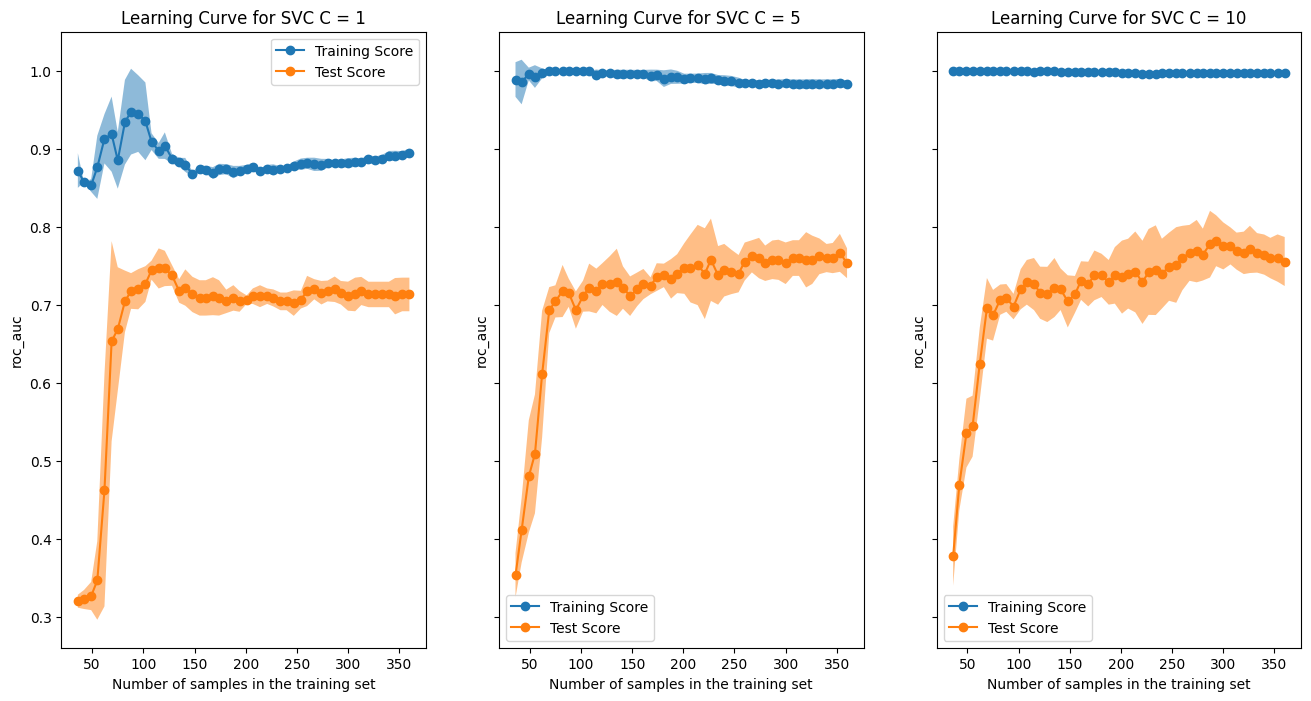

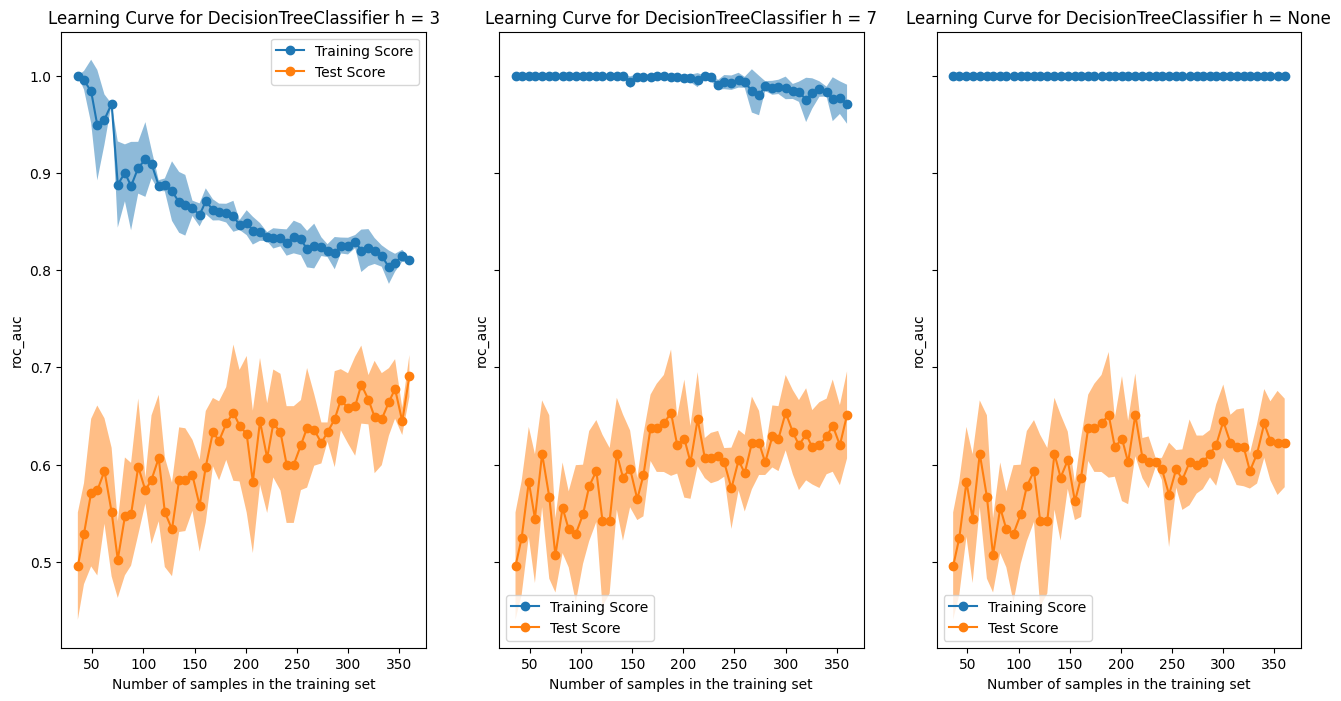

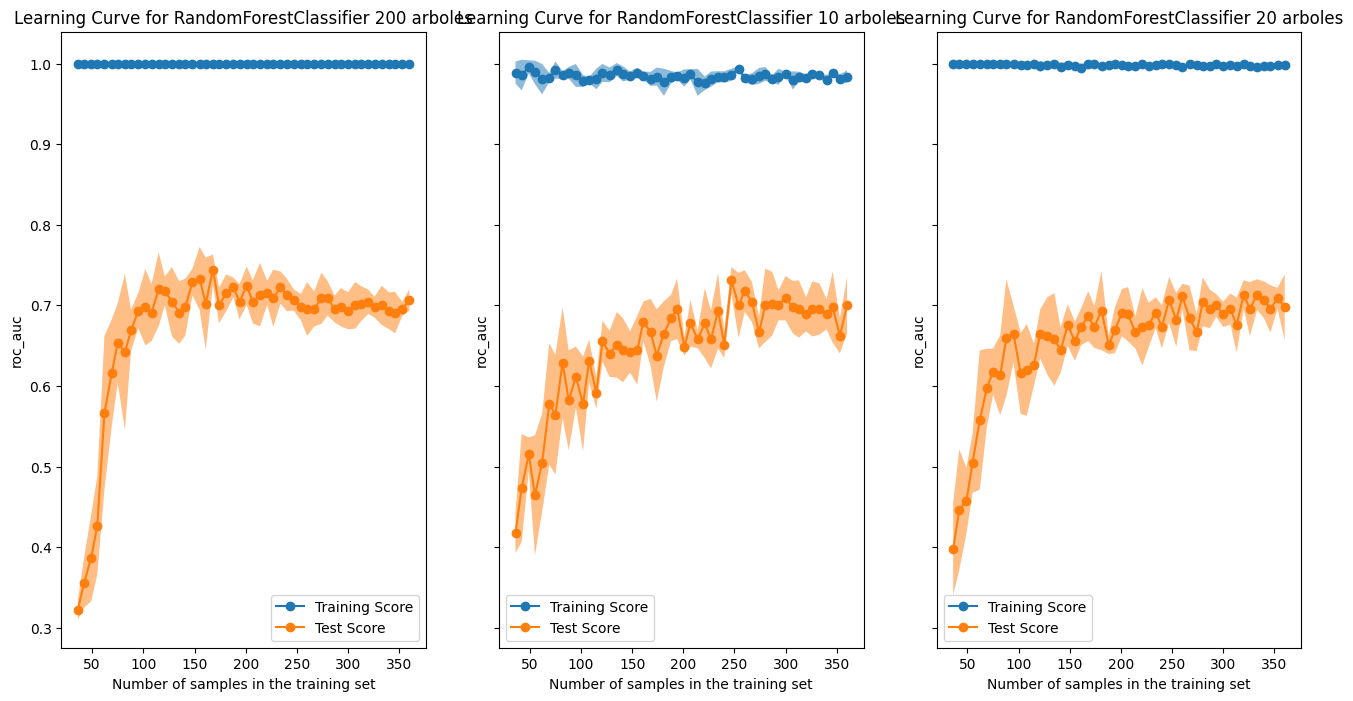

In [20]:
plot_learning_curves(svms, Svm_params)

plot_learning_curves(arboles, arbol_params)

plot_learning_curves(bosques, bosque_params)

In [21]:
from sklearn.metrics import roc_auc_score

def valores_curva_aprendizaje (model):
    print(model)
    # Divide los datos en train y set
    df_train_curva , df_test_curva =  train_test_split(df_dev,train_size=0.8)

    X_train_curva = df_train_curva.drop(columns=['target']).values
    y_train_curva = df_train_curva['target'].values
    X_test_curva   = df_test_curva.drop(columns=['target']).values
    y_test_curva   =  df_test_curva['target'].values

    train_sizes = (np.linspace(0.1, 1.0, 50) * len(X_train_curva)).round().astype(int)
    train_scores = []
    test_scores = []

    for train_size in train_sizes:
        # Nos quedamos con las primeras train_size filas
        X_train_subset = X_train_curva[:train_size]
        y_train_subset = y_train_curva[:train_size]

        # Entrenamos el modelo en el subconjunto
        model.fit(X_train_subset, y_train_subset)

        # Calculamos los scores en ambos subjconjuntos y los agregamos a la lista
        train_score = roc_auc_score(y_train_subset, model.predict(X_train_subset))
        test_score = roc_auc_score(y_test_curva, model.predict(X_test_curva))

        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return train_scores, test_scores, train_sizes

In [22]:
def plot_learning_curves2(models,modelParams):

        fig, ax = plt.subplots(nrows=1, ncols=len(models), figsize=(16, 8), sharey=True)

        for ax_idx, model in enumerate(models):
          
            train_scores, test_scores, train_sizes = valores_curva_aprendizaje (model)
            
            ax[ax_idx].plot(train_sizes, train_scores, label='Training score')
            ax[ax_idx].plot(train_sizes, test_scores, label='Test score')
            
            ax[ax_idx].legend(["Training Score", "Test Score"])
            ax[ax_idx].set_title(f"Learning Curve for {model.__class__.__name__}{modelParams[ax_idx]}")

        plt.show()



#FALTA TUNEAR, REFERENCIAS EN EJES, ETC
#Y="ROC_auc"
#x="train size"

SVC(C=1, kernel='poly')
SVC(C=5, kernel='poly')
SVC(C=10, kernel='poly')


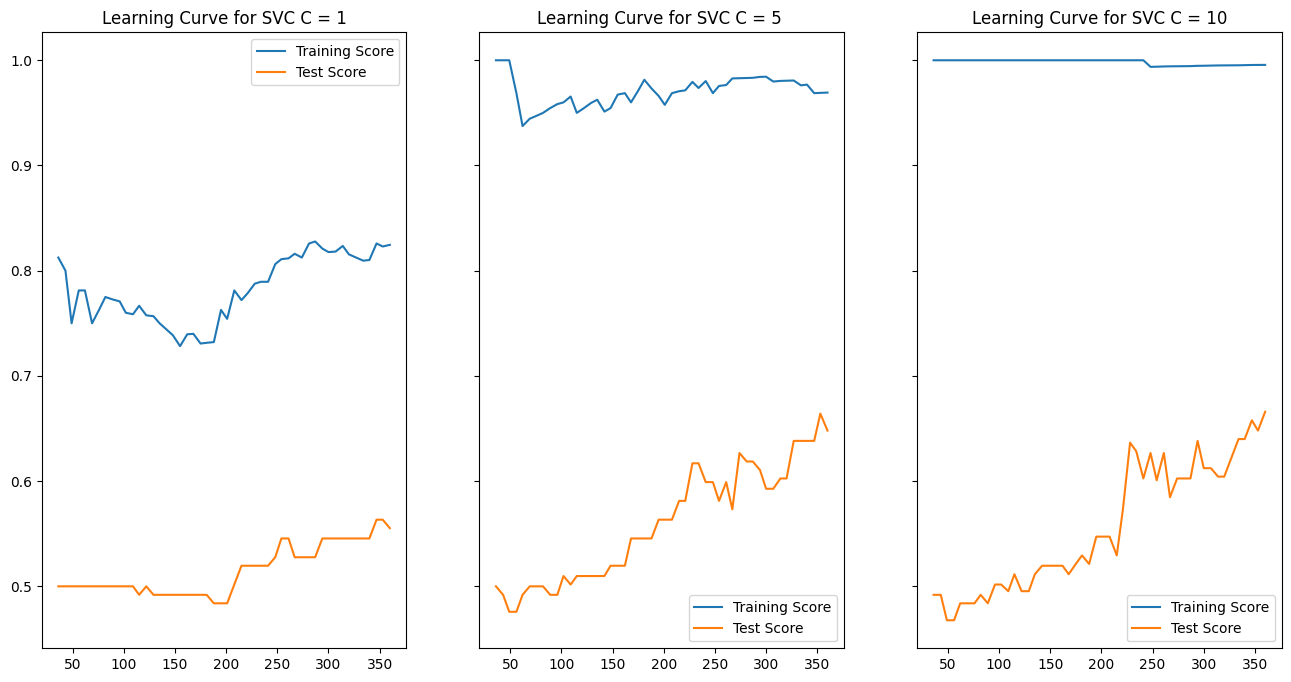

DecisionTreeClassifier(max_depth=3, random_state=51)
DecisionTreeClassifier(max_depth=7, random_state=51)
DecisionTreeClassifier(random_state=51)


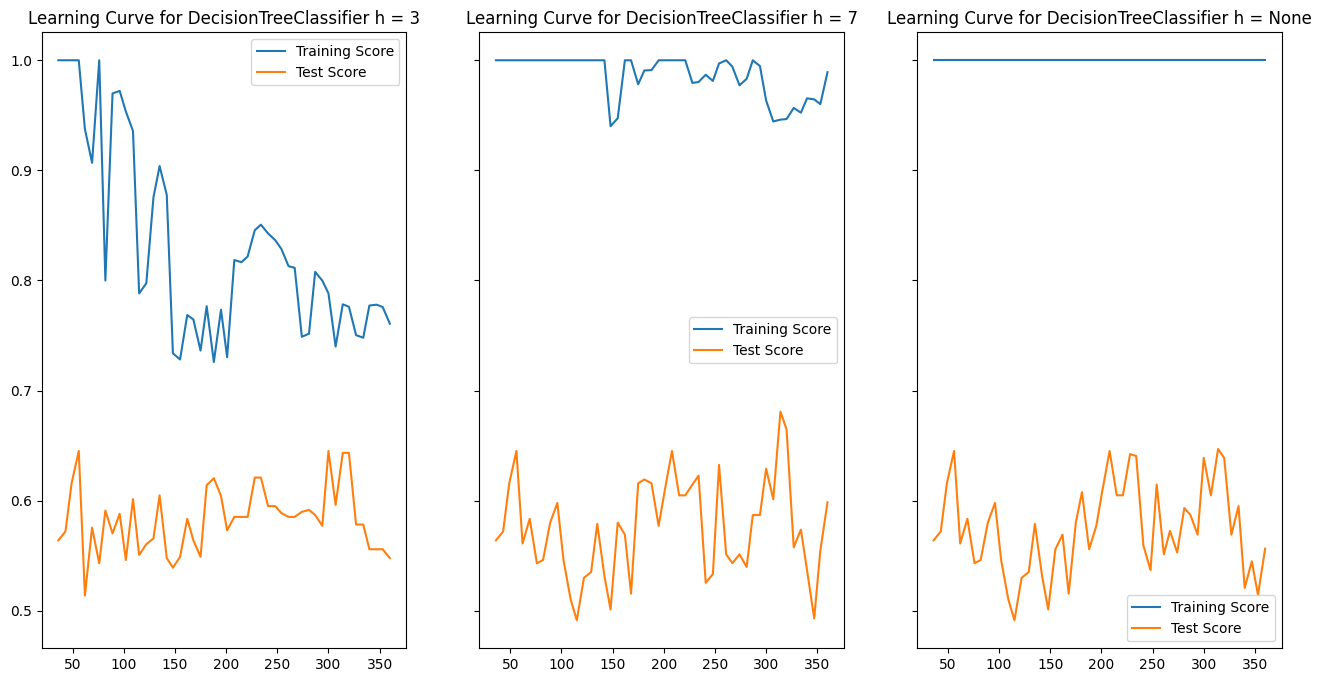

RandomForestClassifier(n_estimators=200)
RandomForestClassifier(n_estimators=10)
RandomForestClassifier(n_estimators=20)


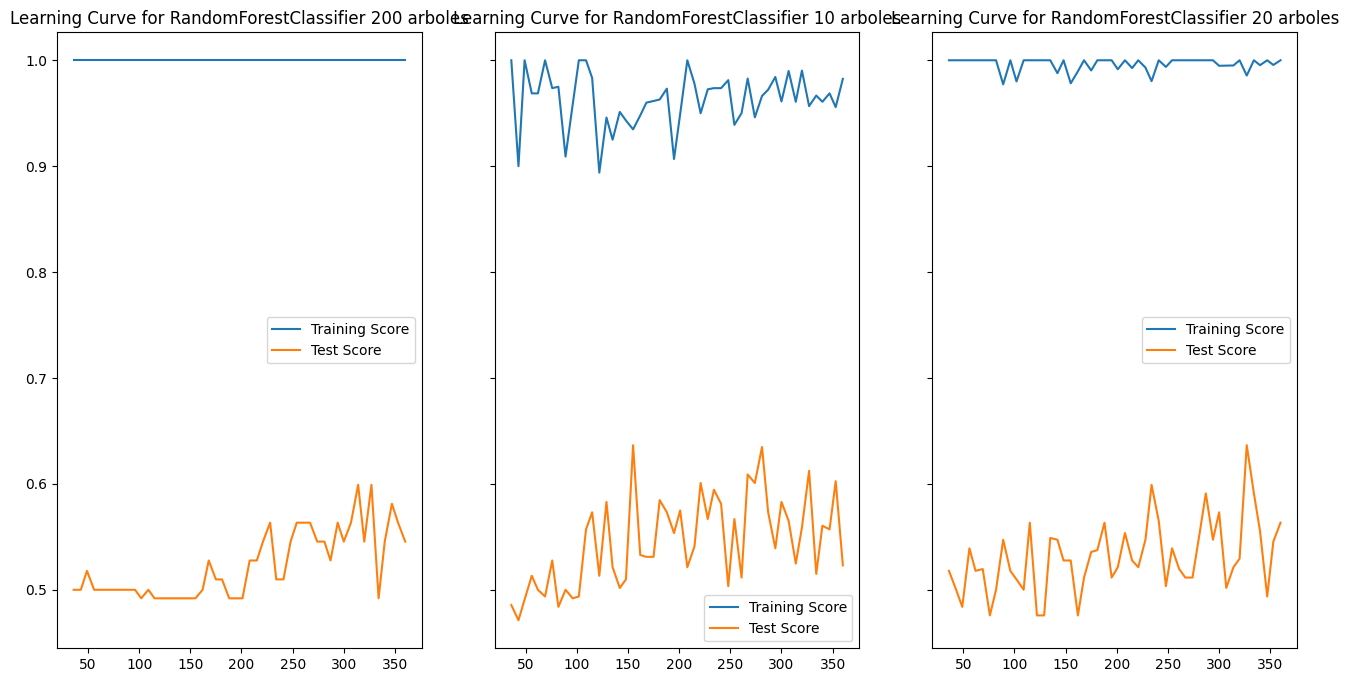

In [23]:
plot_learning_curves2(svms, Svm_params)

plot_learning_curves2(arboles, arbol_params)

plot_learning_curves2(bosques, bosque_params)